# 本筆記讓大家有概念，如何使用pretrained model來做圖像分類。

以下程式碼大多參考自Keras作者François Chollet的 [**教學**](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) 以及他的書：[deep-learning-with-python](https://www.manning.com/books/deep-learning-with-python)。於新版Keras(```v2.1.2```)下，他的範例無法執行，故我有稍做修正。

# 筆記內容：

* [略為了解一下資料集](#01)
* [利用pretrained model建置模型](#02)
* [模型微調](#03)

In [1]:
# =========================================================================
# 由於課堂上可能有多人共用同一顆GPU，以下限定使用者只能用計算卡上45%的記憶體。
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95 # 使用45%記憶體
set_session(tf.Session(config=config))
# =========================================================================

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np

In [3]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.models import load_model
from keras.models import Model

## <a id='01'>略為了解一下資料集</a>

In [4]:
num_train_dogs,=!ls ../datasets/cats_and_dogs/train/dogs | wc -l
num_train_cats,=!ls ../datasets/cats_and_dogs/train/cats | wc -l
num_test_dogs,=!ls ../datasets/cats_and_dogs/validation/dogs | wc -l
num_test_cats,=!ls ../datasets/cats_and_dogs/validation/cats | wc -l

print("狗的train/test張數=",num_train_dogs,num_test_dogs)
print("貓的train/test張數=",num_train_cats,num_test_cats)

狗的train/test張數= 1000 400
貓的train/test張數= 1000 400


看一張貓的照片:

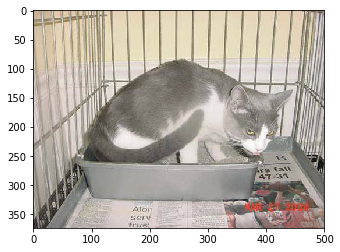

In [5]:
# 隨機載入一張貓的圖片
fig_idx=np.random.choice(1000)
img=cv2.imread("../datasets/cats_and_dogs/train/cats/cat.%s.jpg"%fig_idx)
# 繪圖
plt.imshow(img[:,:,::-1])
plt.show()

看一張狗的照片:

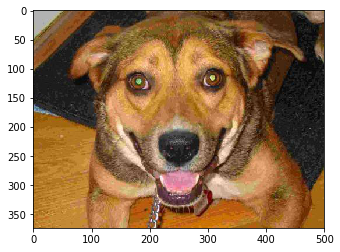

In [6]:
# 隨機載入一張狗的圖片
fig_idx=np.random.choice(1000)
img=cv2.imread("../datasets/cats_and_dogs/train/dogs/dog.%s.jpg"%fig_idx)
# 繪圖
plt.imshow(img[:,:,::-1])
plt.show()

[回索引](#%E7%AD%86%E8%A8%98%E5%85%A7%E5%AE%B9%EF%BC%9A)

## 訓練模型

In [7]:
!ls -hl ../pretrain_models/

total 584M
-rw-r--r-- 1 1000 1000 528M Sep 29 01:13 vgg16_weights_tf_dim_ordering_tf_kernels.h5
-rw-r--r-- 1 1000 1000  57M Sep 29 01:13 vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


In [8]:
# 紀錄兩個放置模型參數的檔案路徑
path_with_top="../pretrain_models/vgg16_weights_tf_dim_ordering_tf_kernels.h5"
path_without_top="../pretrain_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
# #看一下模型架構(without top)
# model = applications.VGG16(weights=path_without_top, include_top=False)
# model.summary()

In [ ]:
# #看一下模型架構(with top)
# model = applications.VGG16(weights=path_with_top, include_top=True)
# model.summary()

### <a id='02'>利用pretrained model建置模型</a>

我們即將建立的模型可分為兩個部分：pretrained convolutional part以及final classification part。

其中，pretrained convolutional part是由已經訓練好的VGG16模型擷取而出。這個模型是由ImageNet資料集訓練而來。

而final classification part並無看過任何資料集，他裡面的參數是被隨機初始化的。

我們將pretrained convolutional part結合後面的final classification part之後，丟入貓狗資料集，來訓練final classification part內的參數。於訓練過程中，我們不會訓練pretrained convolutional part，因為它隱含一些能夠用來分類貓狗的"規則"。我們只會訓練final classification part裡面的參數。

In [9]:
train_data_dir = '../datasets/cats_and_dogs/train/'           # 訓練資料位置
validation_data_dir = '../datasets/cats_and_dogs/validation/' # 驗證資料位置


# 建立VGG 16網路(前面conv block的部分)
conv_base = applications.VGG16(weights=path_without_top,
                               include_top=False,
                               input_shape=(150,150,3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/15
100/100 [==============================] - 25s 254ms/step - loss: 0.5568 - acc: 0.7055 - val_loss: 0.3005 - val_acc: 0.8887
Epoch 2/15
100/100 [==============================] - 22s 222ms/step - loss: 0.3280 - acc: 0.8625 - val_loss: 0.2451 - val_acc: 0.9112
Epoch 3/15
100/100 [==============================] - 23s 226ms/step - loss: 0.2548 - acc: 0.9000 - val_loss: 0.1312 - val_acc: 0.9375
Epoch 4/15
100/100 [==============================] - 22s 224ms/step - loss: 0.2043 - acc: 0.9105 - val_loss: 0.1330 - val_acc: 0.9512
Epoch 5/15
100/100 [==============================] - 21s 214ms/step - loss: 0.1816 - acc: 0.9330 - val_loss: 0.2087 - val_acc: 0.9200
Epoch 6/15
100/100 [==============================] - 22s 220ms/step - loss: 0.1619 - acc: 0.9345 - val_loss: 0.0988 - val_acc: 0.9575
Epoch 7/15
100/100 [==============================] - 23s 226ms/step - loss: 0.1362 - acc: 0.9450 - val_los

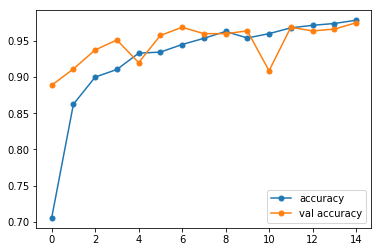

In [10]:
train_data_dir = '../datasets/cats_and_dogs/train/'           # 訓練資料位置
validation_data_dir = '../datasets/cats_and_dogs/validation/' # 驗證資料位置


# 建立VGG 16網路(前面conv block的部分)
conv_base = applications.VGG16(weights=path_without_top,
                               include_top=False,
                               input_shape=(150,150,3))
# 於conv block之後附加一個用於分類的block
x = Flatten()(conv_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(1, activation='sigmoid')(x)
# 將conv block和末端用於分類的block結合成一個模型
model = Model(conv_base.input, preds)
# 告知模型，不需要訓練前面的conv layers (我們只要訓練後面用於分類的block)
conv_base.trainable = False
# 編譯模型，告知模型訓練方式
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
# ============================================================
# 產生train/test generator。generator會從資料夾內撈出一個批次的圖，
# 並將該批次的圖像做augmentation。
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
        train_data_dir,                                       
        target_size=(150, 150),                          
        batch_size=20,
        class_mode='binary')                             

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
# ============================================================

# 訓練模型。圖片將以generator的方式餵入模型。
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50)
#畫出訓練過程
plt.plot(history.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(history.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

[回索引](#%E7%AD%86%E8%A8%98%E5%85%A7%E5%AE%B9%EF%BC%9A)

練習：試著自建一個簡單的CNN模型(不超過5個Convolutional layer)，看你能達成多高的模型準確率。

In [20]:
# 練習於此
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Activation
model = Sequential()
model.add(Conv2D(150, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(Conv2D(150, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation="relu") )
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

# model.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
# ============================================================
# 產生train/test generator。generator會從資料夾內撈出一個批次的圖，
# 並將該批次的圖像做augmentation。
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
        train_data_dir,                                       
        target_size=(150, 150),                          
        batch_size=20,
        class_mode='binary')                             

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
# ============================================================

# 訓練模型。圖片將以generator的方式餵入模型。
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=10)
#畫出訓練過程
plt.plot(history.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(history.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/15


ValueError: Error when checking target: expected activation_5 to have shape (10,) but got array with shape (1,)

[回索引](#%E7%AD%86%E8%A8%98%E5%85%A7%E5%AE%B9%EF%BC%9A)

### <a id='03'>模型微調</a>

先看一下模型架構：

In [ ]:
model.summary()

我們這次除了訓練後面的classification part，我們還多訓練了convolutional part的最後一個block (block 5)。

我們不建議將整個convolutional part去做訓練，因為該part的最前面幾個layer內含一些基本的特徵擷取器，可能相當適合拿來用於我們的貓狗圖片分類。

但是，該part的最後幾個layer，可能內含較高階，較複雜的特徵擷取器，是比較適合ImageNet圖片集的，可能不是完全適合用於我們的貓狗圖片分類。故，以下，我們將那幾個layer調整成可訓練。

In [ ]:
# 將conv block5調整為可訓練
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
# 編譯模型，告知模型訓練方式
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])
# 訓練模型
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50)
# 畫出訓練過程
plt.plot(history.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(history.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

[回索引](#%E7%AD%86%E8%A8%98%E5%85%A7%E5%AE%B9%EF%BC%9A)